In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import warnings 
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, SimpleRNN
from sklearn.model_selection import KFold, GridSearchCV
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import tensorflow as tf

# Our dependant variables are two variables (generation solar, generation wind onshore). 
# But here, we are just predicting "generation solar"
import pandas as pd

In [2]:

df = pd.read_csv('../Data/df_clean.csv',index_col="time")
df_important = df[['price_prev_1','price day ahead','hour','price_prev_2','price_prev_3','forecast solar day ahead','generation solar','generation other renewable','temp_Madrid','temp_Seville','price actual']]
X = df_important.drop(columns = ['price actual'])
y_price = df_important['price actual']

In [3]:
# Split the data into train and test based on specific time '2017-12-31 23:00:00+00:00'
def split_by_date(X,train_end_date):
    if not isinstance(train_end_date, pd.Timestamp):
        train_end_date = pd.Timestamp(train_end_date)

    # Convert index of X and y to Timestamp objects if they are strings
    if isinstance(X.index[0], str):
        X.index = pd.to_datetime(X.index)
        
    X_train = X[X.index <= train_end_date]
    X_test = X[X.index > train_end_date]
    
    return X_train, X_test

train_end_date = pd.to_datetime('2017-12-31 23:00:00+00:00')
X_train, X_test = split_by_date(X,train_end_date)
y_price_train, y_price_test = split_by_date(y_price, train_end_date)

In [4]:
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

In [5]:
scaler_y = StandardScaler()
y_price_train_scaled = scaler_y.fit_transform(y_price_train.values.reshape(-1, 1))
y_price_test_scaled = scaler_y.transform(y_price_test.values.reshape(-1, 1))

In [6]:
def split_array(X_arr, y_arr, n_hours):
    X, y = list(), list()
    for window_start in range(len(X_arr)):
        past_end = window_start + n_hours
        if past_end + 1 > len(X_arr):
            break
        past, future = X_arr[window_start:past_end], y_arr[past_end]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)
        
        

n_hours = 3 # For example, use the previous 24 hours  
X_train_split, y_train_split =split_array(X_train_scaled, y_price_train_scaled,n_hours)
test_train24_combine_X = np.concatenate([X_train_scaled[-n_hours:],X_test_scaled ])
test_train24_combine_y = np.concatenate([y_price_train_scaled[-n_hours:],y_price_test_scaled])
X_test_split, y_test_split = split_array(test_train24_combine_X, test_train24_combine_y , n_hours)

In [9]:
def create_rnn_model(n_neurons):
    model = Sequential()
    model.add(SimpleRNN(n_neurons, input_shape=(n_hours, n_features)))
    model.add(Dense(1))  # No activation function for regression
    model.compile(optimizer='adam', loss='mse')  # Using mean squared error for regression
    return model


n_features = X_train.shape[1]
n_neurons = [10, 20, 30]
param_grid = dict(model__n_neurons=n_neurons)

model_candi = KerasRegressor(model=create_rnn_model)
grid_rnn_3 = GridSearchCV(model_candi, param_grid, cv=5, n_jobs=-1).fit(X_train_split, y_train_split.reshape(-1,1))


822/822 [==============================] - 3s 3ms/step - loss: 0.1459


In [10]:
best_rnn_3 = grid_rnn_3.best_estimator_
# es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
history_rnn_3 = best_rnn_3.fit(X_train_split, y_train_split, epochs=50, batch_size=20, validation_split=0.2,
                            verbose=0)

In [12]:
pred_rnn_3 = best_rnn_3.predict(X_test_split).reshape(-1,1)
y_pred_3 = scaler_y.inverse_transform(pred_rnn_3)
y_test_3 = scaler_y.inverse_transform(y_price_test_scaled)
np.sqrt(np.mean((y_pred_3 - y_test_3)**2))

274/274 [==============================] - 1s 2ms/step


3.8730225099424618

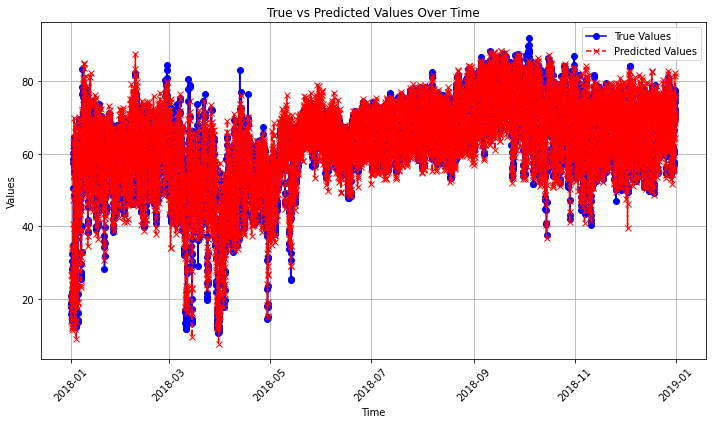

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(X_test.index, y_test_3, marker='o', color='blue', label='True Values')
plt.plot(X_test.index, y_pred_3, marker='x', color='red', linestyle='--', label='Predicted Values')
plt.title('True vs Predicted Values Over Time')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()